<div class="alert alert-info">

## Topic Modeling<a name="2"></a>

In the third step, to utilize reviews effectively, we transformed the textual data into structured features through a process involving topic modeling. This allowed us to identify latent themes in the reviews and use them as features for predictive modeling.

The process of feature extraction included the following steps:

`Text Preprocessing`: The reviews were cleaned and prepared for analysis by removing noise such as stop words, punctuation, and special characters. The text was tokenized, and stemming or lemmatization was applied to normalize the words.

`Applying Topic Modeling`: We used a topic modeling algorithm (`Latent Dirichlet Allocation`) to uncover hidden topics in the reviews. Each topic represented a cluster of related words that encapsulated a specific theme.

`Probability Assignment`: For each review, the model assigned probabilities indicating the likelihood of association with each topic. These probabilities reflected how strongly a review was related to a specific theme.

`Feature Engineering`: Based on the topic probabilities, binary features were created by applying a threshold. If the probability for a topic exceeded the threshold, the corresponding feature was assigned a value of 1; otherwise, it was set to 0. These features represented the presence or absence of specific themes in the reviews for each business.

</div>

In [1]:
#import
import os
import re
import json
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
yelp_df = pd.read_csv('data/yelp_reviews_subset.csv')
yelp_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,review_count,is_open,...,categories,hours,review_id,user_id,stars,useful,funny,cool,text,date
0,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,Nashville,TN,37201,36.162649,-86.775973,593,1,...,"Ice Cream & Frozen Yogurt, Coffee & Tea, Resta...","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ...",ljQTQY59Rjat2CQd02nYbQ,2iS1vg5TYpV_iEiNC8osTg,2,2,1,1,I ducked in here after walking the strip on a ...,2012-09-17 13:59:20
1,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,Nashville,TN,37201,36.162649,-86.775973,593,1,...,"Ice Cream & Frozen Yogurt, Coffee & Tea, Resta...","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ...",smLabVSu-w9VFHA7gNLW6A,ZcNLb0XgmVOPcYvElhz3WA,4,0,0,0,"For a long time, I wondered how long downtown ...",2009-08-13 02:33:39
2,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,Nashville,TN,37201,36.162649,-86.775973,593,1,...,"Ice Cream & Frozen Yogurt, Coffee & Tea, Resta...","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ...",rPZcnwOlfk6IOGXRyRrYCA,TylOr9YYTV3znqIvH7kdmQ,4,1,0,0,"Ice cream in the dead of winter? Yes, it was a...",2010-01-21 04:08:53
3,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,Nashville,TN,37201,36.162649,-86.775973,593,1,...,"Ice Cream & Frozen Yogurt, Coffee & Tea, Resta...","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ...",5ViCByByt6xSFyYvQAwdcw,zfD3xhVNkGJs-AOOSslqtQ,5,0,0,0,Quite possibly the best ice cream I have ever ...,2012-06-17 18:06:28
4,oaboaRBUgGjbo2kfUIKDLQ,Mike's Ice Cream,129 2nd Ave N,Nashville,TN,37201,36.162649,-86.775973,593,1,...,"Ice Cream & Frozen Yogurt, Coffee & Tea, Resta...","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ...",Yx5D1TZWmbjuVerYi6T9eA,KGmDAZI48MtoS_SnSkM0ag,3,0,0,0,This is a great place if you're downtown and w...,2009-01-29 14:18:14


In [3]:
colab_data = yelp_df[['user_id', 'business_id', 'stars']].reset_index(drop=True)
colab_data.head()

,user_id,business_id,stars
0,2iS1vg5TYpV_iEiNC8osTg,oaboaRBUgGjbo2kfUIKDLQ,2
1,ZcNLb0XgmVOPcYvElhz3WA,oaboaRBUgGjbo2kfUIKDLQ,4
2,TylOr9YYTV3znqIvH7kdmQ,oaboaRBUgGjbo2kfUIKDLQ,4
3,zfD3xhVNkGJs-AOOSslqtQ,oaboaRBUgGjbo2kfUIKDLQ,5
4,KGmDAZI48MtoS_SnSkM0ag,oaboaRBUgGjbo2kfUIKDLQ,3


In [4]:
# Number of customers and products
user_key = "user_id"
item_key = "business_id"
N = len(np.unique(colab_data[user_key])) 
M = len(np.unique(colab_data[item_key]))
print(f"Number of customers (N)  : {N}")
print(f"Number of products (M) : {M}")

Number of customers (N)  : 1408
Number of products (M) : 1224


In [5]:
# Data Splitting
from sklearn.model_selection import train_test_split

X = colab_data.copy()
y = colab_data['user_id']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

In [6]:
user_mapper = dict(zip(np.unique(colab_data[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(colab_data[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(colab_data[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(colab_data[item_key])))

In [7]:
# Create utility matrix
def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["stars"]

    return Y

train_mat = create_Y_from_ratings(X_train, N, M)
valid_mat = create_Y_from_ratings(X_valid, N, M)

In [8]:
# Evaluation
def error(Y1, Y2):
    """
    Given two matrices of the same shape, 
    returns the root mean squared error (RMSE).
    """
    # Calculate RMSE
    rmse = np.sqrt(np.nanmean((Y1 - Y2) ** 2))

    # Calculate the range of Y1 (ignoring NaN values)
    range_Y2 = np.nanmax(Y2) - np.nanmin(Y2)

    # Calculate relative RMSE
    relative_rmse = rmse / range_Y2 if range_Y2 != 0 else np.nan

    return rmse


def evaluate(pred_Y, train_mat, valid_mat, model_name="Global average"):
    """
    Given predicted utility matrix and train and validation utility matrices 
    print train and validation RMSEs.
    """
    print("%s train RMSE: %0.2f" % (model_name, error(pred_Y, train_mat)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_Y, valid_mat)))

In [9]:
review_data = yelp_df[['user_id', 'business_id', 'stars', 'text']].reset_index(drop=True)
review_data.head()

,user_id,business_id,stars,text
0,2iS1vg5TYpV_iEiNC8osTg,oaboaRBUgGjbo2kfUIKDLQ,2,I ducked in here after walking the strip on a ...
1,ZcNLb0XgmVOPcYvElhz3WA,oaboaRBUgGjbo2kfUIKDLQ,4,"For a long time, I wondered how long downtown ..."
2,TylOr9YYTV3znqIvH7kdmQ,oaboaRBUgGjbo2kfUIKDLQ,4,"Ice cream in the dead of winter? Yes, it was a..."
3,zfD3xhVNkGJs-AOOSslqtQ,oaboaRBUgGjbo2kfUIKDLQ,5,Quite possibly the best ice cream I have ever ...
4,KGmDAZI48MtoS_SnSkM0ag,oaboaRBUgGjbo2kfUIKDLQ,3,This is a great place if you're downtown and w...


In [10]:
# clean the reviews
# Initialize stopwords and lemmatizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove stopwords and lemmatize
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words)
    return text
# Clean the 'review_body' column
review_data['text_pp'] = review_data['text'].apply(clean_text)

In [11]:
review_data.head()

,user_id,business_id,stars,text,text_pp
0,2iS1vg5TYpV_iEiNC8osTg,oaboaRBUgGjbo2kfUIKDLQ,2,I ducked in here after walking the strip on a ...,ducked walking strip sunday afternoon hot day ...
1,ZcNLb0XgmVOPcYvElhz3WA,oaboaRBUgGjbo2kfUIKDLQ,4,"For a long time, I wondered how long downtown ...",long time wondered long downtown could without...
2,TylOr9YYTV3znqIvH7kdmQ,oaboaRBUgGjbo2kfUIKDLQ,4,"Ice cream in the dead of winter? Yes, it was a...",ice cream dead winter yes lot colder nashville...
3,zfD3xhVNkGJs-AOOSslqtQ,oaboaRBUgGjbo2kfUIKDLQ,5,Quite possibly the best ice cream I have ever ...,quite possibly best ice cream ever small littl...
4,KGmDAZI48MtoS_SnSkM0ag,oaboaRBUgGjbo2kfUIKDLQ,3,This is a great place if you're downtown and w...,great place youre downtown want ice cream kind...


In [12]:
# topic modeling
import gensim
from gensim.corpora import Dictionary
corpus = [doc.split() for doc in review_data["text_pp"].tolist()]
dictionary = Dictionary(corpus)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]

In [13]:
from gensim.models import LdaModel
from gensim.models import CoherenceModel

num_topics = [5,10,15,17,20]

coherence_scores = []
for num in num_topics:
    lda = LdaModel(
        corpus=doc_term_matrix,
        id2word=dictionary,
        num_topics=num,
        random_state=42,
        passes=10,
)
    coherence_model_lda = CoherenceModel(
        model=lda, texts=corpus, dictionary=dictionary, coherence="c_v"
    )
    coherence_scores.append(coherence_model_lda.get_coherence())

In [14]:
df_coherence = pd.DataFrame(coherence_scores, index=num_topics, columns=["Coherence score"])
df_coherence

,Coherence score
5,0.359539
10,0.451492
15,0.464137
17,0.445950
20,0.493353


<Axes: title={'center': 'Coherence scores'}, xlabel='num_topics', ylabel='Coherence score'>

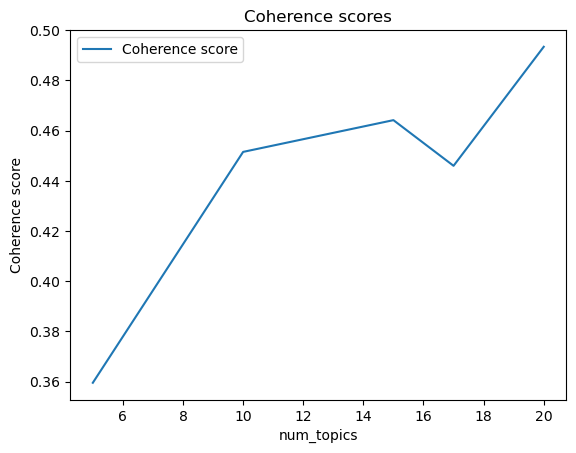

In [15]:
df_coherence.plot(title="Coherence scores", xlabel="num_topics", ylabel="Coherence score")

In [16]:
best_model = LdaModel(corpus=doc_term_matrix,
        id2word=dictionary,
        num_topics=20,
        random_state=42,
        passes=10)

In [17]:
best_model.print_topics(num_words = 10)

[(0,
  '0.015*"dish" + 0.013*"salad" + 0.011*"sauce" + 0.010*"cheese" + 0.009*"meal" + 0.009*"bread" + 0.008*"flavor" + 0.007*"plate" + 0.007*"ordered" + 0.007*"served"'),
 (1,
  '0.046*"oyster" + 0.037*"shrimp" + 0.026*"new" + 0.022*"seafood" + 0.019*"orleans" + 0.016*"fried" + 0.014*"tourist" + 0.012*"crab" + 0.012*"nola" + 0.012*"gumbo"'),
 (2,
  '0.099*"dan" + 0.081*"cheesecake" + 0.041*"han" + 0.026*"dynasty" + 0.022*"wedding" + 0.019*"cupcake" + 0.017*"string" + 0.010*"international" + 0.010*"chris" + 0.010*"croque"'),
 (3,
  '0.020*"u" + 0.014*"time" + 0.014*"table" + 0.013*"ordered" + 0.013*"got" + 0.012*"came" + 0.011*"back" + 0.010*"order" + 0.010*"would" + 0.009*"one"'),
 (4,
  '0.065*"chicken" + 0.039*"pork" + 0.034*"rib" + 0.030*"bbq" + 0.029*"fried" + 0.028*"sauce" + 0.028*"side" + 0.026*"meat" + 0.026*"mac" + 0.023*"cheese"'),
 (5,
  '0.017*"one" + 0.016*"time" + 0.014*"ive" + 0.013*"place" + 0.012*"get" + 0.012*"always" + 0.011*"food" + 0.011*"go" + 0.011*"best" + 0.010

In [18]:
topic_labels = {
    0: "Italian-American Cuisine", 
    1: "Seafood & Cajun Delicacies", 
    2: "Cheesecakes & Specialty Desserts", 
    3: "Dining Experience & General Reviews",
    4: "Barbecue & Comfort Foods", 
    5: "Customer Experience & Loyalty", 
    6: "Breakfast & Brunch Favorites", 
    7: "Burgers & Sandwiches",
    8: "Dining Highlights & Service Quality", 
    9: "Hot Dogs & Local Favorites", 
    10: "Mexican Cuisine & Tacos", 
    11: "Donuts & Pandemic-Era Experiences", 
    12: "Asian Cuisine & Sushi", 
    13: "Coastal Views & Scenic Dining", 
    14: "Venue Atmosphere & Parking", 
    15: "Casual Dining & Food Quality", 
    16: "Desserts & Sweets",
    17: "Pizza & Italian Cuisine", 
    18: "Outdoor Dining & Ambience",
    19: "Bars & Beer Selection"
}

In [19]:
# Step 1: Get topic probabilities for each review
topic_probs = []
for text in review_data['text_pp']:
    bow = dictionary.doc2bow(text.split())  
    topics = best_model.get_document_topics(bow, minimum_probability=0.0)
    topic_probs.append([prob for _, prob in topics])

# Convert topic probabilities to DataFrame
probs_df = pd.DataFrame(topic_probs, columns=[f"Topic_{i}" for i in range(best_model.num_topics)])
review_data = pd.concat([review_data, probs_df], axis=1)

# Step 2: Compute mean probabilities for each topic grouped by business_id
mean_probs = review_data.groupby('business_id')[[f"Topic_{i}" for i in range(best_model.num_topics)]].mean()

# Step 3: Apply the threshold
threshold = 0.3
business_topics = (mean_probs > threshold).astype(int).reset_index()

# Rename columns to use the topic labels
business_topics.columns = ['business_id'] + [topic_labels[i] for i in range(best_model.num_topics)]

# Display the resulting DataFrame
business_topics.head()

,business_id,Italian-American Cuisine,Seafood & Cajun Delicacies,Cheesecakes & Specialty Desserts,Dining Experience & General Reviews,Barbecue & Comfort Foods,Customer Experience & Loyalty,Breakfast & Brunch Favorites,Burgers & Sandwiches,Dining Highlights & Service Quality,...,Mexican Cuisine & Tacos,Donuts & Pandemic-Era Experiences,Asian Cuisine & Sushi,Coastal Views & Scenic Dining,Venue Atmosphere & Parking,Casual Dining & Food Quality,Desserts & Sweets,Pizza & Italian Cuisine,Outdoor Dining & Ambience,Bars & Beer Selection
0,-0TffRSXXIlBYVbb5AwfTg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-1B9pP_CrRBJYPICE5WbRA,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,-1XSzguS6XLN-V6MVZMg2A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-6JdVK-DHB4_43PEksbg1A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-ATiAtTikuGuqvaW2O6tNA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
features_topic = [
    "Italian-American Cuisine", 
    "Seafood & Cajun Delicacies", 
    "Cheesecakes & Specialty Desserts", 
    "Dining Experience & General Reviews",
    "Barbecue & Comfort Foods", 
    "Customer Experience & Loyalty", 
    "Breakfast & Brunch Favorites", 
    "Burgers & Sandwiches",
    "Dining Highlights & Service Quality", 
    "Hot Dogs & Local Favorites", 
    "Mexican Cuisine & Tacos", 
    "Donuts & Pandemic-Era Experiences", 
    "Asian Cuisine & Sushi", 
    "Coastal Views & Scenic Dining", 
    "Venue Atmosphere & Parking", 
    "Casual Dining & Food Quality", 
    "Desserts & Sweets",
    "Pizza & Italian Cuisine", 
    "Outdoor Dining & Ambience",
    "Bars & Beer Selection"
]
business_features_topic = business_topics[features_topic]
business_features_topic.head()

,Italian-American Cuisine,Seafood & Cajun Delicacies,Cheesecakes & Specialty Desserts,Dining Experience & General Reviews,Barbecue & Comfort Foods,Customer Experience & Loyalty,Breakfast & Brunch Favorites,Burgers & Sandwiches,Dining Highlights & Service Quality,Hot Dogs & Local Favorites,Mexican Cuisine & Tacos,Donuts & Pandemic-Era Experiences,Asian Cuisine & Sushi,Coastal Views & Scenic Dining,Venue Atmosphere & Parking,Casual Dining & Food Quality,Desserts & Sweets,Pizza & Italian Cuisine,Outdoor Dining & Ambience,Bars & Beer Selection
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
item_feats_topic = business_features_topic.to_numpy()
item_feats_topic.shape

(1224, 20)

In [22]:
from collections import defaultdict


def get_X_y_per_user_topic(colab_data, d_topic=item_feats_topic.shape[1]):
    """
    Returns X and y for each user.

    Parameters:
    ----------
    ratings : pandas.DataFrame
         ratings data as a dataframe

    d : int
        number of item features

    Return:
    ----------
        dictionaries containing X and y for all users
    """
    lr_y_topic= defaultdict(list)
    lr_X_topic = defaultdict(list)

    for index, val in colab_data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        lr_X_topic[n].append(item_feats_topic[m])
        lr_y_topic[n].append(val["stars"])

    for n in lr_X_topic:
        lr_X_topic[n] = np.array(lr_X_topic[n])
        lr_y_topic[n] = np.array(lr_y_topic[n])

    return lr_X_topic, lr_y_topic

In [23]:
d_topic = item_feats_topic.shape[1]
X_train_usr_topic, y_train_usr_topic = get_X_y_per_user_topic(X_train, d_topic)

In [24]:
from sklearn.linear_model import Ridge

models = dict()
pred_lin_reg = np.zeros((N, M))

for n in range(N):
    models[n] = Ridge()
    models[n].fit(X_train_usr_topic[n], y_train_usr_topic[n])
    pred_lin_reg[n] = models[n].predict(item_feats_topic)
    
evaluate(pred_lin_reg, train_mat, valid_mat, model_name="Content-based recommenders")

Content-based recommenders train RMSE: 0.85
Content-based recommenders valid RMSE: 0.92


In [25]:
# Compare different thresholds for feature creation
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
results = []

for threshold in thresholds:
    print(f"Testing threshold: {threshold}")
    
    # Apply threshold to generate features
    business_topics = (mean_probs > threshold).astype(int).reset_index()
    business_topics.columns = ['business_id'] + [topic_labels[i] for i in range(best_model.num_topics)]
    business_features_topic = business_topics[features_topic]
    item_feats_topic = business_features_topic.to_numpy()
    
    # Train and evaluate Ridge model
    pred_lin_reg = np.zeros((N, M))
    for n in range(N):
        models[n] = Ridge()
        models[n].fit(X_train_usr_topic[n], y_train_usr_topic[n])
        pred_lin_reg[n] = models[n].predict(item_feats_topic)
    
    train_rmse = error(pred_lin_reg, train_mat)
    valid_rmse = error(pred_lin_reg, valid_mat)
    results.append((threshold, train_rmse, valid_rmse))
    print(f"Threshold: {threshold}, Train RMSE: {train_rmse:.2f}, Valid RMSE: {valid_rmse:.2f}")

Testing threshold: 0.1
Threshold: 0.1, Train RMSE: 0.94, Valid RMSE: 1.01
Testing threshold: 0.2
Threshold: 0.2, Train RMSE: 0.87, Valid RMSE: 0.94
Testing threshold: 0.3
Threshold: 0.3, Train RMSE: 0.85, Valid RMSE: 0.92
Testing threshold: 0.4
Threshold: 0.4, Train RMSE: 0.87, Valid RMSE: 0.92
Testing threshold: 0.5
Threshold: 0.5, Train RMSE: 0.87, Valid RMSE: 0.92


In [26]:
# Convert results to a DataFrame for easy visualization
results_df = pd.DataFrame(results, columns=['Threshold', 'Train RMSE', 'Valid RMSE'])
results_df

,Threshold,Train RMSE,Valid RMSE
0,0.1,0.943900,1.010633
1,0.2,0.868514,0.938465
2,0.3,0.845261,0.919258
3,0.4,0.870925,0.918407
4,0.5,0.873581,0.918618


<div class="alert alert-info">

## Result Comparison<a name="2"></a>

By transforming customer reviews into structured features using topic modeling, we analyzed the impact of different thresholds on model performance. The threshold determines how strongly a review must be associated with a topic to be considered relevant, affecting the balance between feature richness and noise.

The results demonstrate that the threshold has a significant impact on feature quality and model performance. A threshold of 0.3 offers the optimal balance, providing features that maximize predictive power while minimizing noise. Lower thresholds (e.g., 0.1) lead to overfitting due to feature overload, while higher thresholds (e.g., 0.5) overly simplify the feature space, slightly degrading model accuracy. This analysis highlights the importance of selecting an appropriate threshold when using topic-model-based features for predictive modeling.
</div>